In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_vals(obj):
    fig, ax = plt.subplots(1, 3, sharey=True)
    ax[0].plot(obj.log_law, obj.z)
    ax[0].set_xlabel("U (m/s)")
    ax[0].set_ylabel("z (m)")

    ax[1].plot(obj.tke, obj.z)
    ax[1].set_xlabel("TKE (m2/s2)")

    ax[2].plot(obj.epsilon, obj.z)
    ax[2].set_xlabel("Dissipation (m2/s3)")

    fig.suptitle(obj.title)

In [4]:
class RH:
    """ 
    Inlet**  conditions from Rhichards and Hoxey 1993

    - title: (String) title for plot 
    - z_0: (Scalar) aerodynamic roughness length 
    - z: (Array of Scalars) list of z values on which to perform calculations (should be np array)
    - u_star: (Bool or Scalar) if friction velocity provided, no need to calculate 
    - u_ref: (Scalar (magnitude) or Bool) reference velocity for calculating friction velocity u_star. Called U_h in RH 
    - z_ref: (Scalar or Bool) reference height for calculating friction velocity u_star. Called h in RH 
    """
    def __init__(self, title, z_0, z,  u_star,  u_ref=False, z_ref=False, c_mu=0.09):
        self.K = 0.41 # von Karman constant 
        self.u_ref = u_ref
        self.z_ref = z_ref
        self.z_0 = z_0
        self.z = z 
        self.c_mu = c_mu
        self.title = title
        if u_star:
            self.u_star = u_star
        else:
            self.u_star = False
        # values to be calculed, initialize to None
        self.log_law = None
        self.tke = None
        self.epsilon = None

    def calc_u_star(self):
        """ friction velocity, u_star"""
        top = self.K * self.u_ref
        bottom = np.log((self.z_ref + self.z_0)/self.z_0)
        self.u_star = top/bottom
        print(f"u_star = {self.u_star}")


    def calc_log_law(self):
        coeff = self.u_star / self.K
        inner = (self.z + self.z_0)/self.z_0
        self.log_law = coeff*np.log(inner)
        # print(f"log_law = {self.log_law}")

    def calc_tke(self):
        result = np.square(self.u_star)/np.sqrt(self.c_mu)
        # turn into an array with length of z 
        self.tke = np.full(len(self.z), result)
        # print(f"tke = {self.tke}")
   

    def calc_epsilon(self):
        top = np.power(self.u_star, 3) # inlet condition, eq 22 is square, but eq 8 is cubed, and is also cubed in of, so doing that here 
        bottom = self.K * (self.z + self.z_0)
        self.epsilon = top/bottom
        # print(f"epsilon = {self.epsilon}")

    def calc_and_plot(self):
        if not self.u_star:
            self.calc_u_star()
        self.calc_log_law()
        self.calc_tke()
        self.calc_epsilon()

        plot_vals(self)




In [80]:
class OFATM:
    """ Profiles (not sure if inlet profiles) from OF 2112 documentation of atmBoundaryLayer. Similar to RH, but with adjustments

    - RH: builds on RH class, so need an object with a defined u_star to be passed in 
    
    """
    def __init__(self, title, RH, C1 = 0, C2 = 1):
        self.RH = RH
        self.C1 = C1
        self.C2 = C2
        self.z = self.RH.z
        self.title = title
        # calculate the modification 
        inner =(self.RH.z + self.RH.z_0)/RH.z_0
        self.mod = np.sqrt(self.C1*np.log(inner) + self.C2)

    def calc_log_law(self):
        # no modification of log law 
        self.log_law = self.RH.log_law
        # print(f"log_law = {self.log_law}")

    def calc_tke(self):
        # tke from RH is an array of all same values 
        self.tke = self.RH.tke[0]*self.mod
        # print(f"tke = {self.tke}")
   

    def calc_epsilon(self):
        self.epsilon = self.RH.epsilon*self.mod
        # print(f"epsilon = {self.epsilon}")

    def calc_and_plot(self):
        self.calc_log_law()
        self.calc_tke()
        self.calc_epsilon()

        plot_vals(self)


# 2011 Parente (PG)

In [87]:
# 2011 Parente Gorle 
z = np.linspace(0,1,71)
z_o = 0.00075 # m 
u_star = 0.374 # m/s
PG = RH("RH Inlet Conditions on 2011 PG WT", z_o, z, u_star)

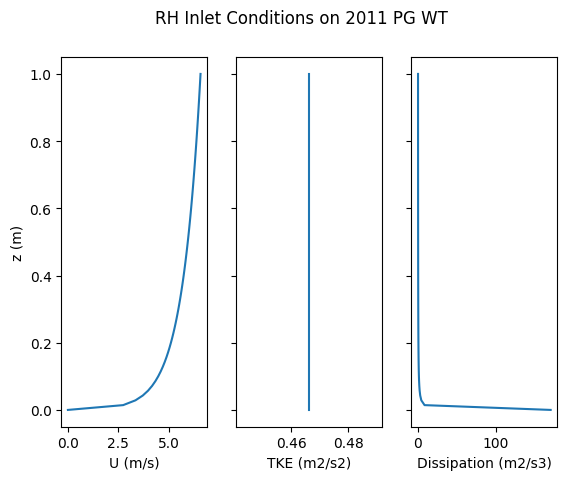

In [88]:
PG.calc_and_plot()

- seem to have appropriate profiles, however value of TKE is 3x larger than in paper, and turbulent dissipation has similar problem 
- although in paper they have plotted mean profile, where here I have plotted inlet ...
- after change dissipation to be cubed of u_star, profiles look more similar, although TKE still too big 
- ok fixed tke by changing Cmu from 0.009 to 0.09, as per openfoam documentation of atmBoundaryLayer -> now looks like paper, except for this profile is constant 

# Hargreaves 

In [12]:
z = np.linspace(0,500,500)
z_o = 0.01 # m 
u_star = False # m/s
u_ref = 10
z_ref = 6
HAR = RH("Hargreaves Inlet Conditions, Expected", z_o, z, u_star, u_ref, z_ref)


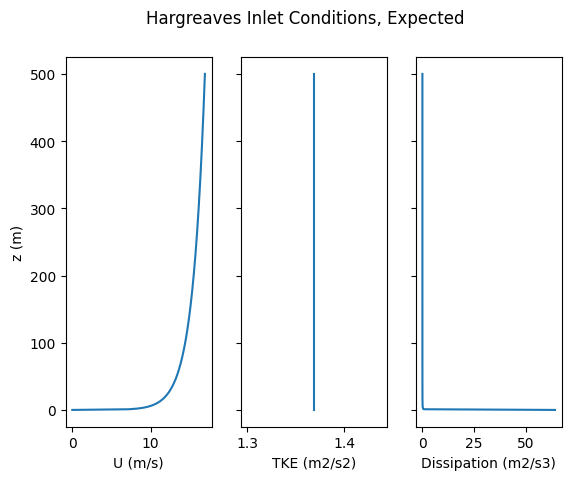

In [14]:
HAR.calc_and_plot()

# Original y+ model (current on 09/08/22)

In [89]:
z = np.linspace(0,3,50)
z_o = 0.00075 # m 
u_star = False # m/s
u_ref = 5
z_ref = 3
YP = RH("RH Inlet Conditions on my Original YP Model", z_o, z, u_star, u_ref, z_ref) # 09/08/22

u_star = 0.24715769825952102


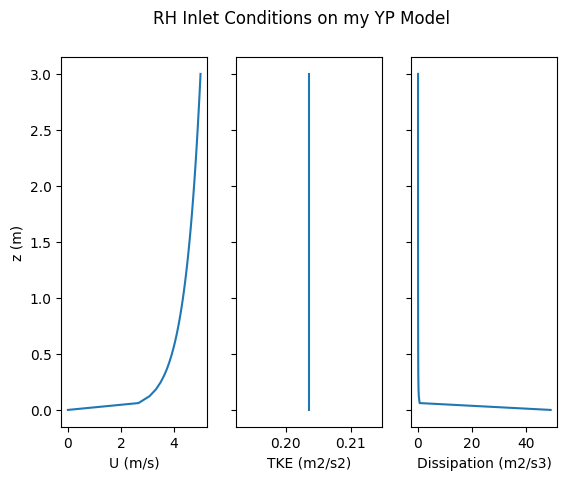

In [90]:
YP.calc_and_plot()

In [91]:
OFYP = OFATM("Openfoam Conditions on my YP Model", YP) 

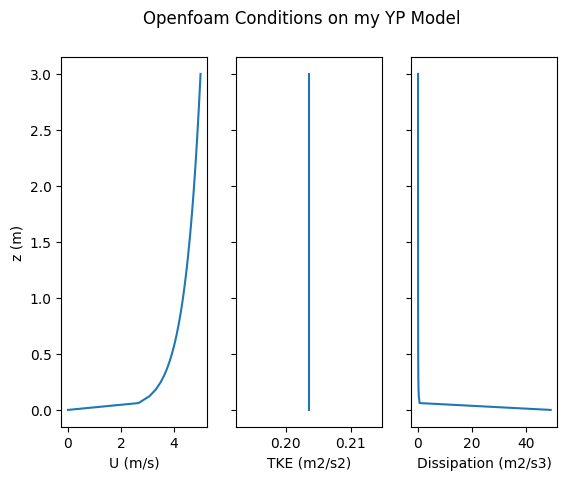

In [92]:
OFYP.calc_and_plot()

- no change when C1 = 0 and C2 = 1, which are the default values 

# Current YP with super low U_ref 

u_star = 0.024715769825952104


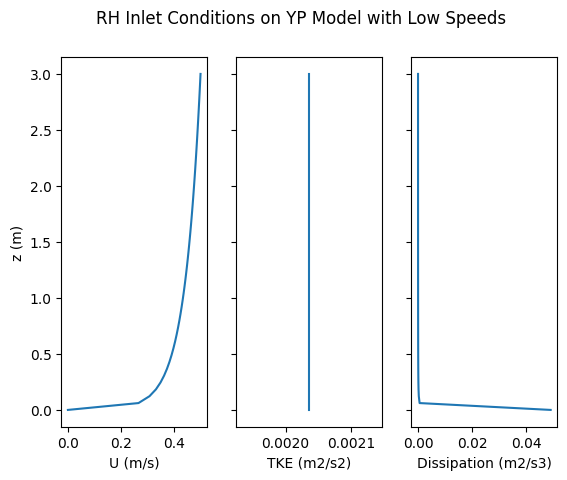

In [93]:
z = np.linspace(0,3,50)
z_o = 0.00075 # m 
u_star = False # m/s
u_ref = 0.5
z_ref = 3
YP0 = RH("RH Inlet Conditions on YP Model with Low Speeds", z_o, z, u_star, u_ref, z_ref)
YP0.calc_and_plot()

- can see that the dissipation and TKE are low compared to PG and YP
- should make model with similar profiles as PG, then figure out what YP needs to be 

# YPG
- more reasonable values

u_star = 0.34602077756332944


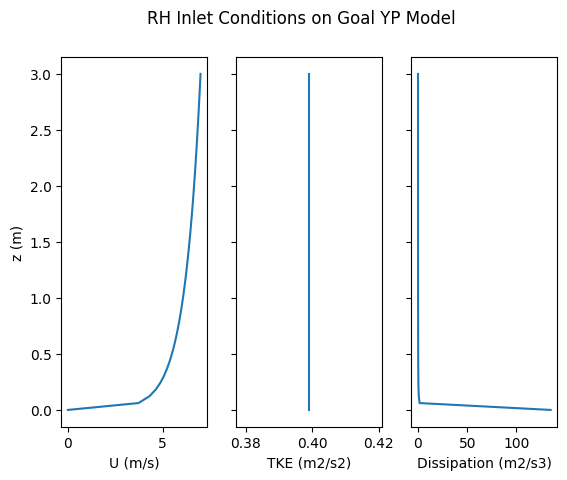

In [4]:
z = np.linspace(0,3,50)
z_o = 0.00075 # m 
u_star = False # m/s
u_ref = 7
z_ref = 3
YPG = RH("RH Inlet Conditions on Goal YP Model", z_o, z, u_star, u_ref, z_ref)
YPG.calc_and_plot()

In [6]:
tau = YPG.u_star**2 # should be a rho in here but idk 
tau

0.11973037850553112

In [151]:
print(f"K = {YPG.tke[0]}, eps_bottom = {YPG.epsilon[0]}, eps_top = {YPG.epsilon[-1]}")

K = 0.39910126168510374, eps_bottom = 134.72910136076624, eps_top = 0.03367385687597257


In [7]:
# nu_t = mu_t / rho 
nu_t_bottom = YPG.c_mu * np.square(YPG.tke[0]) / YPG.epsilon[0]
nu_t_top = YPG.c_mu * np.square(YPG.tke[0]) / YPG.epsilon[-1]

print(f"nut_bottom {nu_t_bottom} nut_top {nu_t_top} ")

nut_bottom 0.00010640138910072382 nut_top 0.425711957791996 


- u_ref of 7 m/s at z = 3 m gives a reasonable profile compared to PG

In [11]:
# omega 
omega_bottom = (YPG.u_star/(YPG.K * np.sqrt(YPG.c_mu) )) *(1/YPG.z_0)
omega_bottom

3750.9027378138694

In [13]:
omega_bottom = (YPG.u_star/(YPG.K * np.sqrt(YPG.c_mu) )) *(1/0.01)
omega_bottom

281.31770533604026

## Calculate mesh grading 

In [98]:
# y+ = y*u_star/nu 
nu = 1e-05
yp_curr = YPG.z*YPG.u_star/nu # assuming z are cell centers even thugh thats wrong 
yp_curr

array([     0.        ,   2118.49455651,   4236.98911302,   6355.48366953,
         8473.97822604,  10592.47278255,  12710.96733906,  14829.46189557,
        16947.95645208,  19066.45100859,  21184.9455651 ,  23303.44012161,
        25421.93467812,  27540.42923463,  29658.92379114,  31777.41834765,
        33895.91290416,  36014.40746067,  38132.90201718,  40251.39657369,
        42369.8911302 ,  44488.38568671,  46606.88024322,  48725.37479973,
        50843.86935624,  52962.36391275,  55080.85846926,  57199.35302577,
        59317.84758229,  61436.3421388 ,  63554.83669531,  65673.33125182,
        67791.82580833,  69910.32036484,  72028.81492135,  74147.30947786,
        76265.80403437,  78384.29859088,  80502.79314739,  82621.2877039 ,
        84739.78226041,  86858.27681692,  88976.77137343,  91095.26592994,
        93213.76048645,  95332.25504296,  97450.74959947,  99569.24415598,
       101687.73871249, 103806.233269  ])

- can see these values are very high, nowhere near desire 30 < yp < 300

In [106]:
# equations coming from Notion, plotting note / fluid mechanics 101 video on Inflation Layers 
# determine d99, boundary layer height, where 99% of velocity is reached
# TODO write equations down in note 
L = 20 
Re = YPG.u_ref * 20 /nu
print(f"Re , {Re}") #  ~ 14e6 > 5e5
d99 =0.38*L / (Re**(1/5))
print(f"d99 , {d99}")

Re , 13999999.999999998
d99 , 0.282870713006647


In [147]:
# determine yh, the height of the first cell 
# 10 cells in d99, 40 outside 
# cell_height_normal = 
N = 15 # number of layers in d99
CN = 95 # current number of cells 
cell_height_normal = (2 - d99)/(CN - N)
cell_height_normal

0.021464116087416912

In [148]:
yh_n = 0.0212 # end cell heighht, height of nth cell in bl --> from calculator, enter total length as d99, and N as 10. expansion ration should be between 1.05 and 1.3   TODO figure out this calchttps://openfoamwiki.net/index.php/Scripts/blockMesh_grading_calculation
yh = 0.016
g = 1.3 # expansion ratio 


height_trans = cell_height_normal - yh_n
np.round(height_trans,5) # 0.013 was too high as was when n = 90 


0.00026

In [141]:
# construct a new array and test 
z0 = yh /2
z0

yp0 = z0*YPG.u_star/nu
yp0 # ~ 422 when N = 10, which is too large, change N to 15, then is 276 which is ok 
# TODO graph of what y+ vals should be 

276.8166220506635

In [142]:
# for block mesh 
# percent of distance 
p_dist = np.round(d99/3,3)
print(f"p dist {p_dist}%, rest {1 - p_dist}%")


p dist 0.094%, rest 0.906%


In [149]:
# percent of cells
p_cells_bl  = np.round(N/CN,3)
print(f"p dist {p_cells_bl}%, rest {1 - p_cells_bl}%")


p dist 0.158%, rest 0.842%
